# 🧠 ADG-CLIP

**Authors**: Filippo Adami, Alessandro De Vidi, and Matteo Grisenti

**Student IDs**: 256149, 257845, 257855

---

## Project Overview

This notebook presents our solution for the Deep Learning 2025 course project.  
The objective of the assignment is to improve performance of a pre-trained Vision-Language Model (VLM) on the Oxford Flowers102 dataset, using either Zero or Few Shot approaches.

In this work, we focus on designing a solution that **relies entirely on Zero-Shot capabilities**, without fine-tuning the model or being tailored to a single dataset. Our approach leverages two main ideas:
- **LLM-generated prompts:** crafted using a reliable knowledge base generated at runtime using LLM-powered web search. These prompts are designed to provide visually richer and more discriminative textual information to the CLIP model and add determinism to the generated prompts. (*Since the retrieval is takes time and resources, we already precomputed it*)
- **Image augmentations:** applied at runtime to the test samples to generate multiple views and variations of each image using an optimized version of the [Zero-1-to-3](https://arxiv.org/abs/2303.11328) diffusion model (*Since the generation takes a lot of time on the T4 + cpu offload (40 seconds per image) we already augmented the entire dataset and uploaded it to github, from where we then simply download it*). This helps the visual encoder capture additional visual cues and improve similarity estimation.

The notebook is self-contained and executable from start to finish in Google Colab. We document our methodology, evaluation, and analysis in detail. Additionally, we include an **Appendix** where we describe several approaches that were tested but ultimately abandoned during our development process and computationally heavy **deterministic** steps that
were precomputed to spare time.

## 1. Motivations & Supporting Literature

Few-shot adaptation remains a challenging task in computer vision, particularly for fine-grained classification problems where categories may differ only by subtle visual cues. Vision-language models (VLMs) like CLIP ([Radford et al., 2021](https://arxiv.org/abs/2103.00020)) offer a powerful foundation for such tasks due to their ability to perform zero-shot classification by embedding images and text in a shared semantic space. However, CLIP's performance can be limited when prompts are overly generic or when the visual input lacks sufficient detail due to constrained viewpoints or dataset bias.

In this project, we propose a Zero-Shot adaptation strategy that enhances both the **textual** ([Menon et al., 2022](https://arxiv.org/abs/2210.07183)) and **visual** ([Feng et al., 2024](https://arxiv.org/abs/2412.09706)) inputs to CLIP, without modifying its architecture or performing any fine-tuning. Our method is adaptable, simple, and effective, and it builds upon ideas explored in recent literature on **prompt generation** ([Maniparambil et al., 2023; Du et al., 2024](https://arxiv.org/abs/2103.00020)) and **diffusion-based image augmentation** ([Feng et al., 2023; Liu et al., 2023](https://arxiv.org/abs/2412.09706)).

Together, these two components can act as a **dual power-up** for CLIP. We think that this combination can grasp improvements from both methods, improving classification accuracy on both Base classes and Novel ones, all within a fully zero-shot framework.

The following sections present our implementation, experimental evaluation on the [Oxford Flowers dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102?hl=it), and insights into the effectiveness and limitations of this approach.


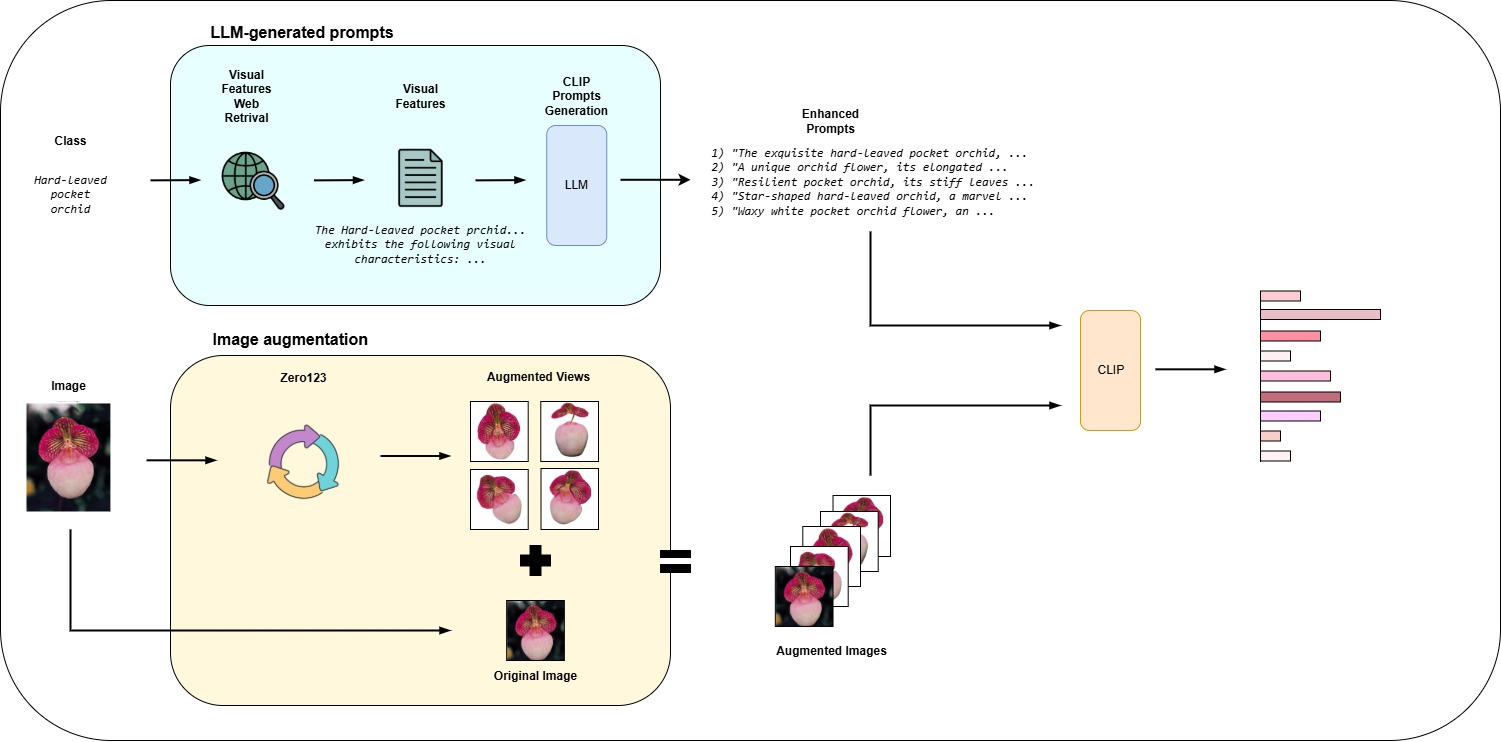

## 2. Setup

### Dependencies installation
In this section, we install the required dependencies, including the CLIP model and our custom github repository containing pre-generated augmented images of flowers (to skip the in-place image generation process and directly use enhanced visual inputs during evaluation)., and the pre-retrieved features for the categories.

In [ ]:
%pip install -q openai_clip
!git clone https://github.com/matteogrisenti/CLIP-zero-shot.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
Cloning into 'CLIP-zero-shot'...
remote: Enumerating objects: 31991, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 31991 (delta 4), reused 6 (delta 1), pack-reused 31979 (from 2)
Receiving objects: 100% (31991/31991), 176.79 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Updating files: 100% (25708/25708), done.


In [ ]:
import os
import gc

import torch
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as TF

import clip

from google import genai
from google.genai import types
from google.colab import userdata

import time
import json
import glob
import random
import contextlib
import numpy as np
from typing import List, Dict, Any
from pydantic import BaseModel, Field

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter

print("✅ All dependencies imported successfully!")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name()}")

✅ All dependencies imported successfully!
🎮 GPU: Tesla T4


### Classes setup
In this cell are contained all the dataset dependent variables. By editing these values, you can seamlessly change dataset.

In [ ]:
def get_base_prompt(c):
    standard_prompt = f"a photo of a {CLASS_NAMES[c]}, a type of flower." # Standard prompt for Flowers102 dataset
    return standard_prompt

from torchvision.datasets import Flowers102 as dataset_used # dataset import

CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]
# variables needed for the features retrieval and the prompts generation template prompts
dataset_name = "Oxford flowers102"
generic_category = "flowers"

print(f"📊 Total {generic_category} classes in dataset: {len(CLASS_NAMES)}")

📊 Total flowers classes in dataset: 102


## 3. Image augmentation

We leverage the Zero-1-to-3 model by [Liu et al.](https://arxiv.org/abs/2303.11328) optimized for Colab T4+CPU ([original GitHub repo](https://github.com/iivek/zero123-accelerate)) to generate novel viewpoints from a single input image.

For our experiment, we decided to generate 4 different viewpoints per image (+30° horizontal, -30° horizontal, +30° vertical, -30° vertical) to avoid too drastic changes (which the model does not support very well), yet obtain the most variation possible out of it.
Since the generation of the views takes more or less 2 minutes in Google Colab we preferred to prepare a dataset with the augmentations of the Flowers102 images.
Below you can find some example views.

100%|██████████| 345M/345M [00:46<00:00, 7.43MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.41MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 21.6MB/s]


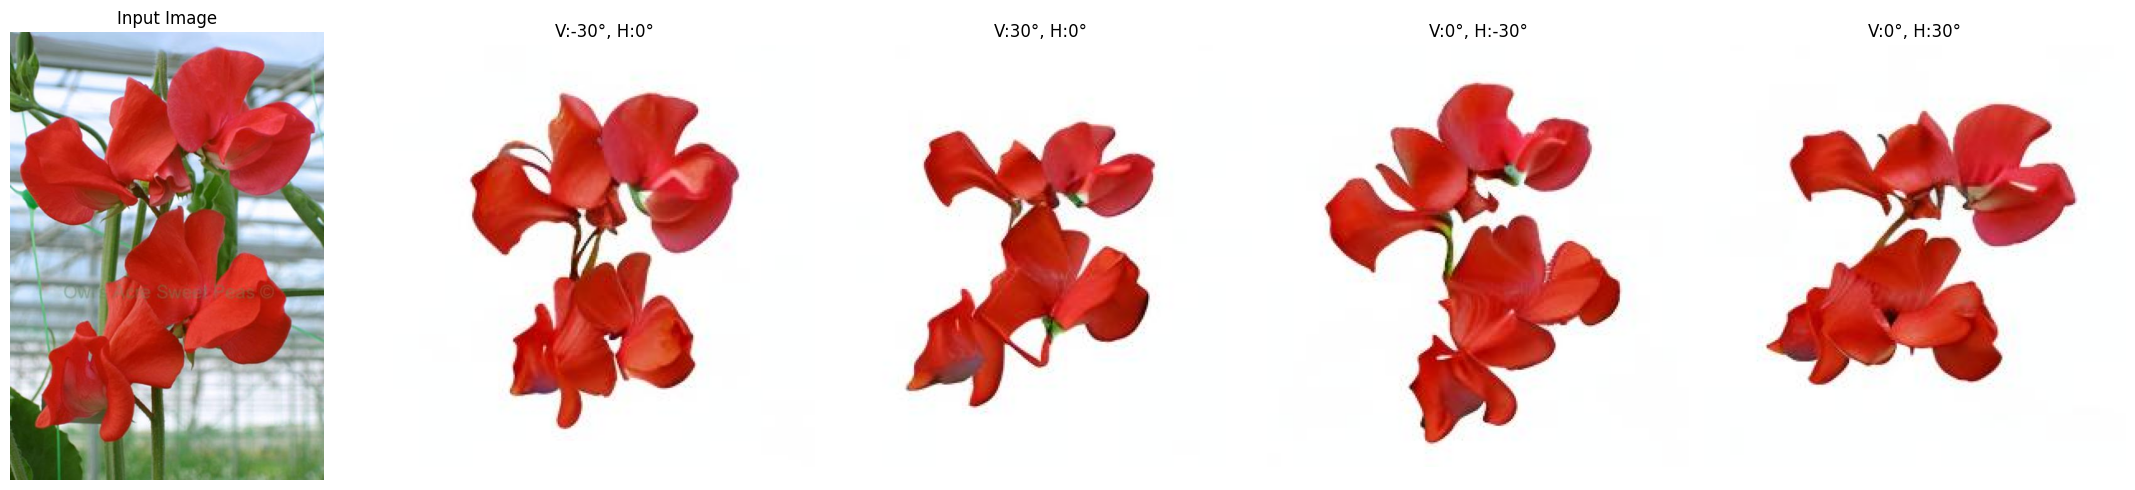

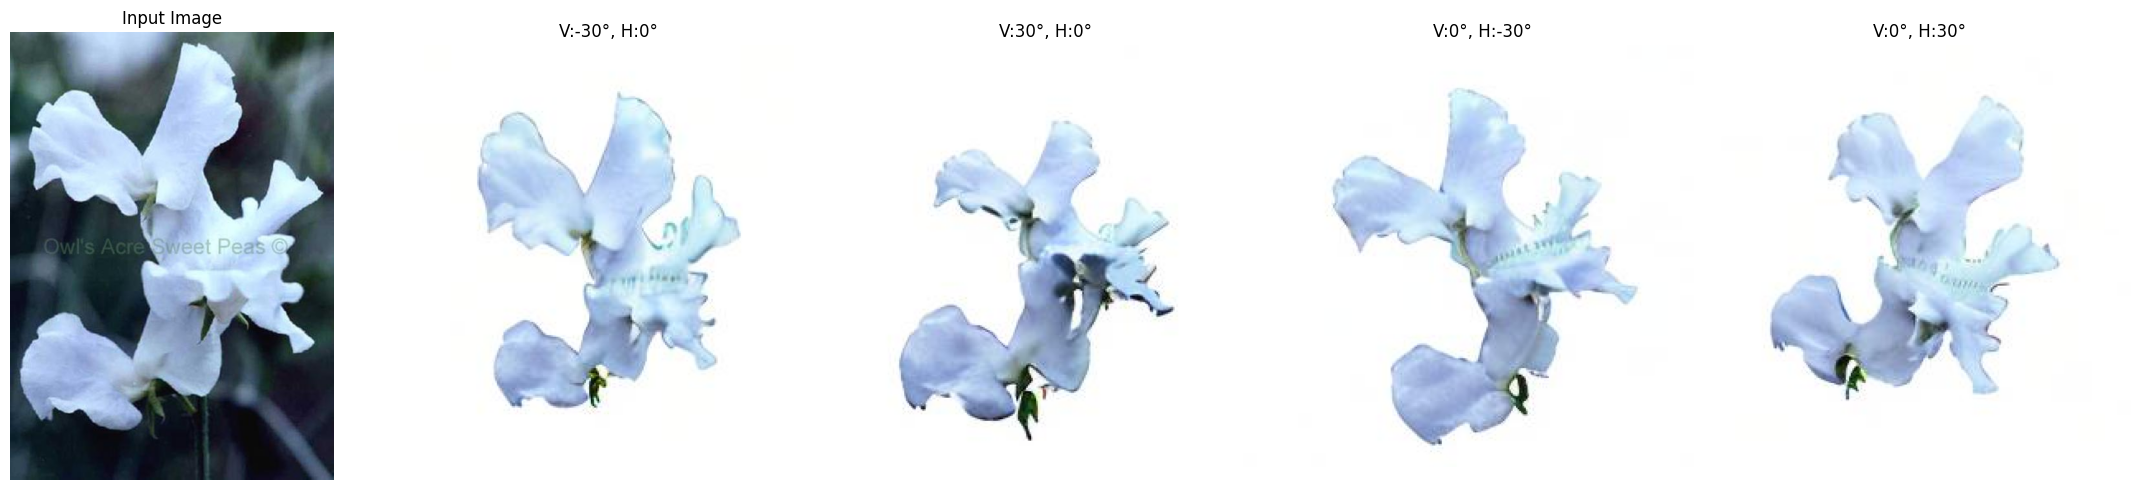

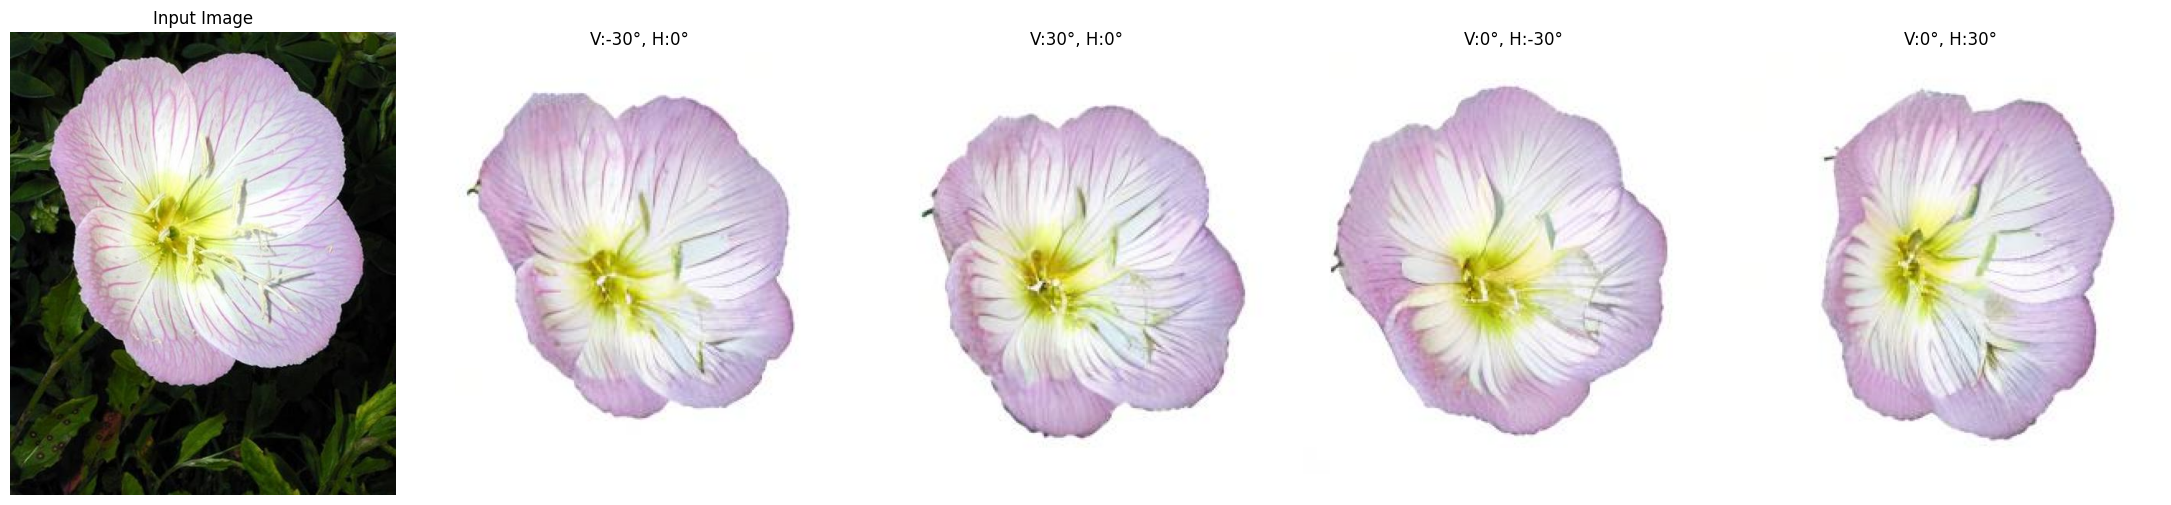

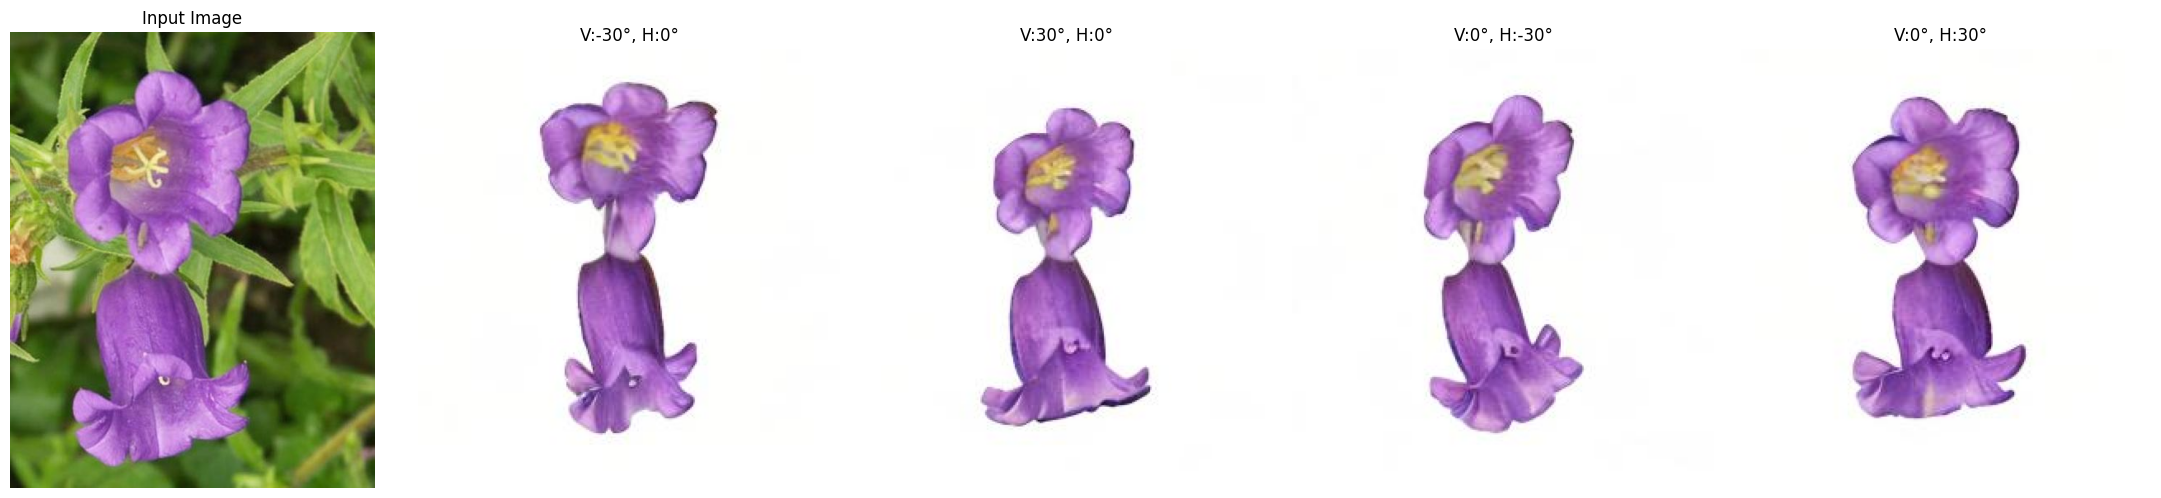

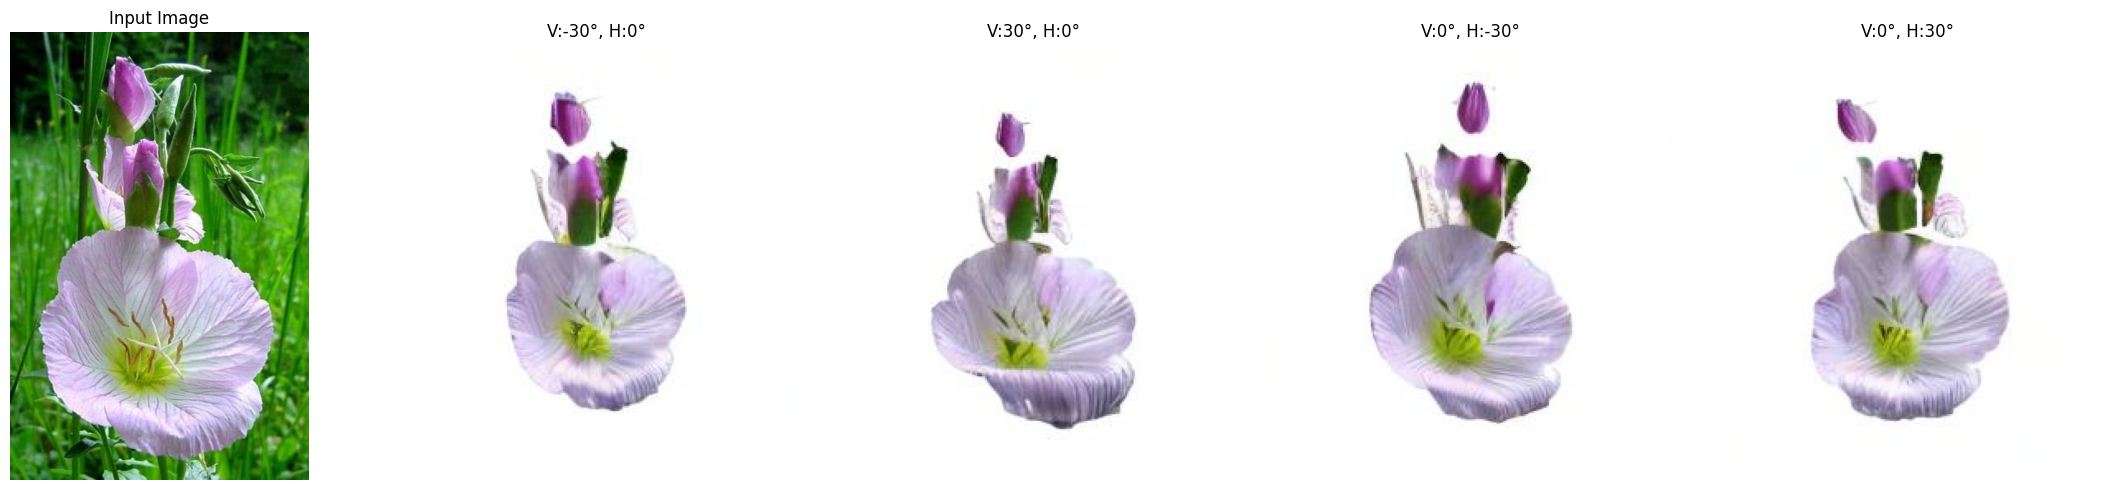

In [ ]:
dataset = dataset_used(root="./data", split="test", download=True) # Dataset download

aug_dataset_path = '/content/CLIP-zero-shot/augmentations'

def show_sample_view(sample_id: int):

    # The augmentations are organized in folders with the sample id as name
    views_path = os.path.join(aug_dataset_path, str(sample_id))

    # Load all images from the folder
    image_paths = sorted(glob.glob(os.path.join(views_path, '*.jpg')))

    all_images = [dataset[sample_id][0]] + [Image.open(p) for p in image_paths]

    # Display in grid
    fig, axs = plt.subplots(1, 5, figsize=(22, 5))
    view_angles = ['Input Image', 'V:-30°, H:0°', 'V:30°, H:0°', 'V:0°, H:-30°', 'V:0°, H:30°']
    for i, img in enumerate(all_images):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(view_angles[i], fontsize=12)

    plt.tight_layout()
    plt.show()

# show 5 random sets of images
random_samples = [random.randint(0, len(CLASS_NAMES)) for i in range(5)]
for sample_id in random_samples:
    show_sample_view(sample_id)

## 4. Prompt generation with LLM

To improve CLIP's zero-shot classification capabilities, we generate **semantically rich and visually grounded prompts** for each category in the dataset. These prompts are created using a multi-stage process involving both web-grounded visual description retrieval and LLM-based prompt crafting.

#### 🔍 Step 1: Visual Feature Extraction (Gemini + Google Search)

We use **Gemini 2.0 Flash (via Google GenAI SDK)** to query the web and summarize the most visually distinctive characteristics of each class (in this case 'flowers'). For every class name:
- A custom engineered prompt template is issued that asks the LLM for visual descriptors specific to that class.
- The LLM is configured to **ground its responses via web search**, ensuring factual, visual details.
- The resulting descriptions (e.g., “tall yellow petals with central black disk”) are saved to a local JSON file for reuse.

This step ensures that our prompts are based on grounded, class-specific visual cues rather than generic internal knowledge. Using them to guide the prompts generation also guarantees a fair degree of determinism, allowing the experiment to be reproduced.

*NB: plain LLM prompt generation without guidance produces accuracy results within a 20% range for both base and novel classes (-15% to +5% w.r.t. baseline CLIP), adding the guidance not only it reduces this gap to 1-3%, but it produces a stable positive increment in accuracy, but that's for later...*

### Gemini model setup

In [ ]:
from google.colab import userdata

# Configure the client
GEMINI_API_KEY = "" # our hardcoded Gemini API Key
client = genai.Client(api_key=GEMINI_API_KEY)

# Define the grounding tool
grounding_tool = types.Tool(
    google_search=types.GoogleSearch()
)

# Configure generation settings for web search
web_call_config = types.GenerateContentConfig(
    tools=[grounding_tool]
)

# Define schema for CLIP LLM generated prompts
class Prompts(BaseModel):
    d1: str
    d2: str
    d3: str
    d4: str
    d5: str
    d6: str
    d7: str

class PromptDescriptions(BaseModel):
    descriptions: List[Prompts] = Field(
        ...,
        min_length=1,
        description="A list where each element is an object with 7 short descriptions for a specific category (d1-d10)."
    )

# Configure generation settings for prompt generation
prompt_gen_config = types.GenerateContentConfig(
    temperature=0.0,
    response_mime_type="application/json",
    response_schema=PromptDescriptions
)

# Here we set the path for the preloaded features.json file (or for the new one if you want to re-generate it using the next cell)
output_filename = "/content/CLIP-zero-shot/features.json"

print("Google GenAI SDK configured successfully!")

Google GenAI SDK configured successfully!


### Dataset categories features web retrieval

❗If you want to delete the preloaded features file and redo it from scratch (not recommended), uncomment the last line of the following cell (It will take you more than 10 minutes, needs to be supervised as Google servers are having some overload problems lately, and use more than 100 API calls!)

In [ ]:
def get_visual_features(class_name, dataset_name, generic_category)->str:
  """
    Function that uses Google search integrated in Gemini API to get a short description of the visual features of a class.

    Args:
        class_name: name of the class (flower's name) of with we want to extract features
        dataset_name: name of the dataset (flowers102)
        base_classes: a general name of the category (e.g. flower)

    Returns:
        A text with the visual features of the class
  """
  # Custom engineered prompt template (we are very proud of it!)
  web_search_prompt = f"""What are the unique visual characteristics that distinguish an object of the class {class_name} within the {dataset_name} dataset?
  If applicable, consider its features in relation to {generic_category} in general.
  Please perform a web search to find reliable references to ensure the accuracy of the visual description.
  Provide a detailed yet concise summary (bullet list style) (max 100 tokens) focusing exclusively on the visual features that are most helpful for differentiating this class from other classes within the dataset.
  You should avoid writing information about the dataset"""

  # Make the request
  response = client.models.generate_content(
      model="gemini-2.0-flash",
      contents=web_search_prompt,
      config=web_call_config,
  )

  # Return the grounded response
  return response.text

def run_get_visual_features_from_web_search():
    starting_index = 0
    features = []

    # --- File and Index Handling ---
    # this piece of code handles redo of the file and keeps track of edits to recover from eventual errors without losing the progress
    if os.path.exists(output_filename):
        try:
            with open(output_filename, 'r') as f:
                features = json.load(f)

            if len(features) == len(CLASS_NAMES):
                print(f"File '{output_filename}' contains all {len(CLASS_NAMES)} features. Restarting from scratch...")
                os.remove(output_filename)
                features = []
                starting_index = 0
            elif len(features) < len(CLASS_NAMES):
                print(f"Found {len(features)} saved features (partial). Resuming from index {len(features)}.")
                starting_index = len(features)
            else:
                print(f"WARNING: Found more features ({len(features)}) than expected classes ({len(CLASS_NAMES)}).")
                print("Truncating to expected number of classes.")
                features = features[:len(CLASS_NAMES)]
                starting_index = len(features)
        except json.JSONDecodeError:
            print(f"Corrupted file '{output_filename}'. Starting from scratch.")
            features = []
            starting_index = 0
    else:
        print(f"No previous file found. Creating new file and starting from scratch.")

    # --- Begin Extraction ---
    print(f"Starting feature extraction from index {starting_index} for {len(CLASS_NAMES) - starting_index} remaining classes...\n")

    last_successfully_saved_index = len(features) - 1 if features else -1 # save last successfull index for precaution

    for i in tqdm(range(starting_index, len(CLASS_NAMES)), desc="Extracting features"):
        class_name = CLASS_NAMES[i]
        print(f"\n--- Processing class {i+1}/{len(CLASS_NAMES)}: '{class_name}' (Index: {i}) ---")

        current_feature_description = None

        try:
            # call the function to get features for the current class
            current_feature_description = get_visual_features(class_name, dataset_name, generic_category)
            # print result for supervision
            print(f"Description of {class_name}:\n{current_feature_description}")
            # here the user can decide to continue if the generation went fine or abort and then restart from last successful step
            user_input = input("Press Enter to save and continue, or A to abort: ").strip().upper()

            if user_input != 'A':
                while len(features) <= i:
                    features.append(None)
                features[i] = current_feature_description
                print(f"Description for '{class_name}' SAVED.")

                with open(output_filename, 'w') as f:
                    json.dump(features, f, indent=4)
                print(f"Features saved to '{output_filename}' (count: {len(features)})")
                last_successfully_saved_index = i
            else:
                print(f"Aborting. Description for '{class_name}' was NOT saved.")
                break

        except Exception as e:
            print(f"\nError on class '{class_name}' (Index {i}): {e}")
            user_input_after_error = input("Error occurred. Press C to save error, A to abort, or anything else to skip: ").strip().upper()

            if user_input_after_error == 'C':
                while len(features) <= i:
                    features.append(None)
                features[i] = f"ERROR at index {i}: {e}"
                print(f"Error placeholder for '{class_name}' SAVED.")

                try:
                    with open(output_filename, 'w') as f:
                        json.dump(features, f, indent=4)
                    last_successfully_saved_index = i
                except Exception as e_save:
                    print(f"Failed to save after error: {e_save}")
            elif user_input_after_error == 'A':
                print("Aborting due to error.")
                break
            else:
                print("Skipping class. Moving to next.")

    # --- Completion Summary ---
    print("\n--- Feature Extraction Finished ---")
    print(f"Final count of features: {len(features)}")
    if last_successfully_saved_index != -1:
        print(f"Last successfully saved class index: {last_successfully_saved_index} (Class: '{CLASS_NAMES[last_successfully_saved_index]}')")
    else:
        print("No classes were saved during this run.")

# uncomment the following line to redo the features exctraction
#run_get_visual_features_from_web_search()


#### 🔍 Step 2: Generation of the prompts for CLIP (batched calls) 🌟

We use **Gemini 2.5 Flash (via Google GenAI SDK)** to generate 7 prompts for each class within the dataset. Why 7? because CLIP text embeddings are shown to perform better with prompts close to 20 tokens (12-15 words) ([Zhang et al., 2024](https://arxiv.org/abs/2403.15378v3)). To grasp all useful visual characteristics retrieved by the previous step without exceeding this quota, we found that 7 is the most efficient compromise. Furthermore, previous work showed that for prompt ensembling (ops, spoiler), it's good practice to keep this number between 5 and 10 ([Schulhoff et al., 2024](https://arxiv.org/abs/2406.06608))([Lau et al.](https://arxiv.org/abs/2412.15238)).

*This step leverages Gemini structured outputt functionalities to guarantee consistent responses.
> 📁 We then save a 'generated_prompt.json' file for later use and to be able to download it and reuse it to spare API calls *

In [ ]:
generated_prompts_for_classes = {}  # {class_name: [list of prompts]}
prompt_batch_size = 34 # this number was decided since the flowers102 dataset has a number of classes that can be divided by 34
# Try to load LLM-generated descriptions
try:
    with open(output_filename, "r") as f:
        classes_features = json.load(f) # look for the features.json file
    has_llm_descriptions = True
    print("✅ Found features file")
    print(f"📊 Loaded features for {len(classes_features)} classes")
except FileNotFoundError:
    print("❌ No features found. Will only run standard evaluation.")
    has_llm_descriptions = False

print("\n--- Generating the prompts for each class using LLM ---")
print("This might take a few minutes depending on the number of classes and API response times.")

for i in tqdm(range(0, len(CLASS_NAMES), prompt_batch_size), desc="Generating prompts in batches"):
    current_batch_classes = CLASS_NAMES[i : min(i + prompt_batch_size, len(CLASS_NAMES))]

    # get descriptionf from features file
    current_batch_descriptions = classes_features[i : min(i + prompt_batch_size, len(classes_features))]

    # create a list with the names of the categories for the current batch
    current_batch_for_llm = []
    for class_name, description_string in zip(current_batch_classes, current_batch_descriptions):
        current_batch_for_llm.append({
            "class_name": class_name,
            "visual_features_description": description_string.strip()
        })
    llm_input_json_string = json.dumps(current_batch_for_llm, indent=4)

    # build the prompt for the current batch
    prompt_batch = f"""You are an expert in visual recognition and prompt engineering for Vision-Language Models (VLMs) like CLIP. Your task is to generate **7 diverse, concise, and highly discriminative text prompts** for each object class, specifically optimized for **zero-shot classification performance with CLIP**.

You will be provided with a JSON list of object classes. For each object class in the list, you will receive:
- `class_name`: The precise name of the object category.
- `visual_features_description`: A detailed and reliable description of its key distinguishing visual characteristics. This description includes features that make the category unique. Rely more on this description than on your knowledge.

**Your Goal:**
For each `class_name` provided, generate exactly **5 distinct and effective text prompts**. These prompts should aim to maximize the accuracy of a CLIP model when classifying images of this particular class.

**Guidelines for Prompt Construction:**
1.  **Direct CLIP Alignment:** Focus exclusively on visual attributes that a VLM like CLIP can effectively recognize from an image. Avoid abstract concepts, misleading ategories names, or non-visual information.
2.  **Leverage Visual Description:** Integrate key details from the `visual_features_description` into your prompts. This is crucial for distinguishing similar classes.
3.  **Attribute Emphasis:** Clearly highlight unique visual traits such as color, shape, pattern, texture, size, or distinctive parts of the object.
4.  **Contextualization & Image Type:** In addition to object-specific contexts, consider the dataset's characteristics. For the current dataset, which is '{dataset_name}', you should sometimes include terms describing the image style (sketch, drawing, professional photo, headshot, etc.) or broader environmental context relevant to the dataset (e.g. day/night, surroundings, distance, feeling).
5.  **Conciseness & Token Limit:** Keep each prompt succinct, aiming for 20 tokens (10-12 words). Focus on high-signal visual words.
6.  **Diversity for Ensembling:** Ensure the 5 prompts for a single class are not mere paraphrases. They should explore different facets of the class's visual identity, leading to diverse embeddings that enhance the power of prompt ensembling.

**Input Classes for Prompt Generation:**
```json
{llm_input_json_string}
```
"""
    # call LLM
    try:
      response_llm = client.models.generate_content(
          model="gemini-2.5-flash",
          contents=prompt_batch,
          config=prompt_gen_config,
      )
      # parse response to get structured object
      parsed_response = PromptDescriptions.model_validate_json(response_llm.text)

      for j, prompt_obj in enumerate(parsed_response.descriptions):
          category_name = current_batch_classes[j]
          generated_prompts_for_classes[category_name] = [
              prompt_obj.d1,
              prompt_obj.d2,
              prompt_obj.d3,
              prompt_obj.d4,
              prompt_obj.d5,
              prompt_obj.d6,
              prompt_obj.d7,
          ]

    except Exception as e:
        print(f"\nError generating prompts for batch starting with '{current_batch_classes[0]}': {e}")
        print(f"Raw response (if available): {response_llm.text if 'response_llm' in locals() else 'N/A'}")

print("\nLLM prompt generation complete.")
# show example prompts
print("\n--- Showing some example prompts ---")
num_examples_to_show = 5

# Ensure we don't exceed the available number of classes
sampled_classes = random.sample(list(generated_prompts_for_classes.keys()), min(num_examples_to_show, len(generated_prompts_for_classes)))

for class_name in sampled_classes:
    prompts = generated_prompts_for_classes[class_name]
    print(f"\n🔹 Category: {class_name}")
    for idx, p in enumerate(prompts, 1):
        print(f"  Prompt {idx}: {p}")


with open("generated_prompts.json", "w") as f:
    json.dump(generated_prompts_for_classes, f, indent=4)


✅ Found features file
📊 Loaded features for 102 classes

--- Generating the prompts for each class using LLM ---
This might take a few minutes depending on the number of classes and API response times.


Generating prompts in batches:   0%|          | 0/3 [00:00<?, ?it/s]


LLM prompt generation complete.

--- Showing some example prompts ---

🔹 Category: peruvian lily
  Prompt 1: A photo of a peruvian lily with trumpet-shaped, speckled petals.
  Prompt 2: A close-up of a peruvian lily, showing its contrasting streaks on petals.
  Prompt 3: An image of a vibrant orange peruvian lily with six petals.
  Prompt 4: A professional photo of a peruvian lily with unique twisted leaves.
  Prompt 5: A detailed shot of a pink peruvian lily, resembling a miniature lily.
  Prompt 6: A beautiful peruvian lily flower, funnel-shaped, with varied colors.
  Prompt 7: A botanical illustration of a peruvian lily, emphasizing its twisted foliage.

🔹 Category: frangipani
  Prompt 1: A photo of a frangipani with propeller-shaped petals.
  Prompt 2: A close-up of a white frangipani with a yellow center.
  Prompt 3: A professional shot of a frangipani cluster at branch ends.
  Prompt 4: An outdoor image of a vibrant pink frangipani with five petals.
  Prompt 5: A beautiful frang

## 5. CLIP


### Memory Optimization functions
The following funcitons are used to optimize VRAM memory management to efficiently run the CLIP model.

In [ ]:
def aggressive_cleanup():
    """
    Comprehensive memory cleanup function to prevent VRAM leaks.

    This function:
    - Forces Python garbage collection
    - Empties CUDA cache
    - Collects IPC (Inter-Process Communication) resources
    - Synchronizes CUDA operations
    """
    gc.collect()                    # Python garbage collection
    torch.cuda.empty_cache()        # Clear CUDA cache
    torch.cuda.ipc_collect()        # Clean up IPC resources
    if torch.cuda.is_available():
        torch.cuda.synchronize()    # Wait for all CUDA operations to complete

def print_memory_stats():
    """Display current GPU memory usage statistics"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # Convert to GB
        reserved = torch.cuda.memory_reserved() / 1024**3    # Convert to GB
        print(f"🔋 GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
    else:
        print("❌ CUDA not available - running on CPU")

In [ ]:
@contextlib.contextmanager
def clip_model_context(model_name="ViT-B/16"):
    """
    Context manager for CLIP model to ensure proper cleanup.

    This ensures that:
    - Model is properly loaded on the correct device
    - Model is set to evaluation mode
    - Memory is cleaned up after use, even if errors occur

    Args:
        model_name: CLIP model variant to load

    Yields:
        model: CLIP model
        preprocess: Image preprocessing function
        device: Device (cuda/cpu) the model is loaded on
    """
    print(f"🤖 Loading CLIP model: {model_name}")
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load CLIP model and preprocessing
    model, preprocess = clip.load(model_name, device=device)
    model.eval()  # Set to evaluation mode

    print(f"✅ CLIP model loaded on {device}")

    try:
        yield model, preprocess, device
    finally:
        # Ensure cleanup happens even if errors occur
        print("🧹 Cleaning up CLIP model...")
        del model
        aggressive_cleanup()

### Dataset utility functions
The following funcitons are used to download the Flowers102 dataset and split the data into base and novel classes. The function has been taken from the notebook presented during lectures.

In [ ]:
def get_data(data_dir="./data", transform=None):
    """Load dataset train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    print("📥 Downloading and loading the dataset...")
    train = dataset_used(root=data_dir, split="train", download=True, transform=transform)
    val = dataset_used(root=data_dir, split="val", download=True, transform=transform)
    test = dataset_used(root=data_dir, split="test", download=True, transform=transform)
    print(f"✅ Dataset loaded - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
    return train, val, test

def base_novel_categories(dataset):
    """
    Split all classes into base and novel categories.

    Base classes: First half of classes (for training/fine-tuning scenarios)
    Novel classes: Second half of classes (for zero-shot evaluation)

    Args:
        dataset: PyTorch dataset object

    Returns:
        base_classes, novel_classes: Lists of class indices
    """
    all_classes = set(dataset._labels)
    num_classes = len(all_classes)

    # Split classes 50/50
    base_classes = list(range(num_classes))[:num_classes//2]
    novel_classes = list(range(num_classes))[num_classes//2:]

    print(f"📊 Class split - Base: {len(base_classes)}, Novel: {len(novel_classes)}")
    return base_classes, novel_classes

def split_data(dataset, base_classes):
    """
    Split dataset samples based on base/novel class membership.

    Args:
        dataset: PyTorch dataset
        base_classes: List of base class indices

    Returns:
        base_dataset, novel_dataset: Subsets containing only base/novel samples
    """
    base_categories_samples = []
    novel_categories_samples = []
    base_set = set(base_classes)

    # Iterate through all samples and categorize by class
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # Create dataset subsets
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)

    print(f"📊 Data split - Base samples: {len(base_dataset)}, Novel samples: {len(novel_dataset)}")
    return base_dataset, novel_dataset


### Text features functions

The following functions are used to get Tensors from prompt for CLIP use.
For LLM generated prompts, as spoilered above, we use **prompt ensembling** technique, which consists in averaging the textual embeddings resulting from each prompt to create a more solid and features-richer representation of the desired category.

In [ ]:
def get_text_features_standard(model, class_ids, device):
    """
    Generate standard CLIP text features using simple template prompts.

    Uses the template: "a photo of a {class_name}, a type of flower."

    Args:
        model: CLIP model
        class_ids: List of class indices to generate features for
        device: Device to run computation on

    Returns:
        text_features: Normalized text embeddings tensor
    """
    # Create simple template prompts
    prompts = [get_base_prompt(c) for c in class_ids]
    print(f"📝 Generated {len(prompts)} standard prompts")
    print(f"📄 Example prompt: '{prompts[0]}'")

    # Tokenize prompts
    text_inputs = clip.tokenize(prompts).to(device)

    try:
        # Generate embeddings
        with torch.no_grad():
            text_features = model.encode_text(text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Create a copy to ensure we don't keep references
        result = text_features.clone()
        return result

    finally:
        # Clean up intermediate tensors
        del text_inputs, text_features
        aggressive_cleanup()

def get_llm_text_features(model, prompt_dict, class_ids, class_names, device):
    """
    Generate text features from LLM-generated prompts.

    For each class, uses multiple detailed prompts generated by an LLM,
    then averages their embeddings to get a richer representation.

    Args:
        model: CLIP model
        prompt_dict: Dictionary mapping class names to lists of prompts
        class_ids: List of class indices
        class_names: List of all class names
        device: Device to run computation on

    Returns:
        text_features: Tensor of averaged normalized embeddings per class
    """
    text_features = []

    print(f"🤖 Processing LLM-generated prompts for {len(class_ids)} classes...")

    for c in class_ids:
        class_name = class_names[c]
        prompts = prompt_dict[class_name]

        # Tokenize all prompts for this class
        text_inputs = clip.tokenize(prompts).to(device)

        try:
            # Generate embeddings for all prompts
            with torch.no_grad():
                embeddings = model.encode_text(text_inputs)
                embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)

                # Average across all prompts for this class
                mean_embedding = embeddings.mean(dim=0)
                mean_embedding = mean_embedding / mean_embedding.norm(dim=-1, keepdim=True)

                # Store the averaged embedding
                text_features.append(mean_embedding.clone())

        finally:
            # Clean up intermediate tensors
            del text_inputs, embeddings, mean_embedding
            aggressive_cleanup()

    return torch.stack(text_features).to(device)

def safe_mean(arr):
    """Safely compute mean, returning 0 if array is empty"""
    return np.mean(arr) if arr else 0.0

###Evaluation function

This function is an adapted version of the evaluation function presented in the notebook during the lessons. We added metrics like top-5 and top-10 prediction to broaden the understanding of our method's performance.

In [ ]:
@torch.no_grad()
def eval(model, dataset, categories, batch_size, device, text_features, label=""):
    """
    Memory-optimized evaluation function for CLIP zero-shot classification.

    Computes:
    - Top-1, Top-5, Top-10 accuracies

    Args:
        model: CLIP model
        dataset: PyTorch dataset to evaluate
        categories: List of class indices for this evaluation
        batch_size: Batch size for evaluation
        device: Device to run on
        text_features: Pre-computed text embeddings
        label: Description label for progress bar

    Returns:
        Dictionary with accuracy metrics
    """

    model.eval()

    # Create mapping from original class IDs to contiguous indices (0, 1, 2, ...)
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # Create dataloader (num_workers=0 to avoid subprocess memory issues in Colab)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=0
    )

    # Initialize counters
    correct_top1 = 0
    correct_top5 = 0
    correct_top10 = 0
    total = 0

    try:
        for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc=label)):
            # Remap targets to contiguous space and move to device
            targets = torch.tensor([contig_cat2idx[t.item()] for t in targets], dtype=torch.long).to(device)
            images = images.to(device)

            # Encode images
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # Compute similarities between images and text
            similarities = image_features @ text_features.T

            # Get top-10 predictions
            top10 = similarities.topk(10, dim=-1)
            top10_indices = top10.indices  # Class predictions
            top10_values = top10.values    # Confidence scores

            # Calculate accuracies
            correct_top1 += (top10_indices[:, 0] == targets).sum().item()
            correct_top5 += sum([targets[i] in top10_indices[i, :5] for i in range(len(targets))])
            correct_top10 += sum([targets[i] in top10_indices[i, :10] for i in range(len(targets))])

            total += targets.size(0)

            # Clean up batch tensors immediately to save memory
            del images, targets, image_features, similarities, top10, top10_indices, top10_values

            # Periodic cleanup during long evaluations
            if batch_idx % 10 == 0:
                aggressive_cleanup()

    finally:
        # Clean up dataloader
        del dataloader
        aggressive_cleanup()

    # Calculate final metrics
    top1_acc = correct_top1 / total
    top5_acc = correct_top5 / total
    top10_acc = correct_top10 / total

    # Display results
    print(f"\n📊 Total samples evaluated: {total}\n")
    print(f"✅ Top-1 Accuracy:      {top1_acc*100:.2f}%")
    print(f"✅ Top-5 Accuracy:      {top5_acc*100:.2f}%")
    print(f"✅ Top-10 Accuracy:     {top10_acc*100:.2f}%")

    return {
        "top1": top1_acc,
        "top5": top5_acc,
        "top10": top10_acc
    }

## 6. Main Run

### Complete pipeline execution

We are finally here! These are the functions that execute and display the results of our method's complete pipeline, plus baseline CLIP for comparison.

In [ ]:
def run_pipeline():
    """
    Run complete evaluation suite with proper memory management.

    Evaluations performed:
    1. Standard prompts on base classes
    2. Standard prompts on novel classes
    3. LLM-enhanced prompts on base classes (if generated_prompts.json file is available)
    4. LLM-enhanced prompts on novel classes (if generated_prompts.json file is available)

    Returns:
        Dictionary containing all evaluation results
    """
    print("🚀 Starting memory-optimized CLIP evaluation suite...")

    # Try to load LLM-generated prompts file
    try:
        with open("generated_prompts.json", "r") as f:
            generated_prompts_for_classes = json.load(f)
        has_llm_prompts = True
        print("✅ Found generated prompts file")
        print(f"📊 Loaded prompts for {len(generated_prompts_for_classes)} classes")
    except FileNotFoundError:
        print("❌ No generated prompts found. Will only run standard evaluation.")
        has_llm_prompts = False

    results = {}

    # Use context manager for proper model lifecycle management
    with clip_model_context("ViT-B/16") as (model, preprocess, device):
        print(f"📱 Using device: {device}")
        batch_sz = 128

        # Load and prepare datasets
        print("\n📥 Loading and preparing datasets...")
        train_set, val_set, test_set = get_data(transform=preprocess)
        base_classes, novel_classes = base_novel_categories(train_set)

        # Split datasets by base/novel classes
        test_base, test_novel = split_data(test_set, base_classes)

        print(f"📊 Dataset prepared:")
        print(f"   Base classes: {len(base_classes)} Novel classes: {len(novel_classes)}")
        print(f"   Test base samples: {len(test_base)} Test novel samples: {len(test_novel)}")

        # EVALUATION 1: Standard Prompts with Standard Dataset
        print("\n" + "="*60)
        print("🔄 EVALUATION 1a: Standard Prompts on Base Classes")
        print("="*60)

        base_text_features = get_text_features_standard(model, base_classes, device)
        try:
            results['standard_base'] = eval(
                model=model,
                dataset=test_base,
                categories=base_classes,
                batch_size=batch_sz,
                device=device,
                text_features=base_text_features,
                label="🧠 Zero-shot evaluation on Base Classes with Standard Prompts"
            )
        finally:
            del base_text_features
            aggressive_cleanup()

        print("\n" + "="*60)
        print("🔄 EVALUATION 1b: Standard Prompts on Novel Classes")
        print("="*60)

        novel_text_features = get_text_features_standard(model, novel_classes, device)
        try:
            results['standard_novel'] = eval(
                model=model,
                dataset=test_novel,
                categories=novel_classes,
                batch_size=batch_sz,
                device=device,
                text_features=novel_text_features,
                label="🧠 Zero-shot evaluation on Novel Classes with Standard Prompts"
            )
        finally:
            del novel_text_features
            aggressive_cleanup()

        # EVALUATIONS 2: LLM-Enhanced Prompts (if prompts available) with Standard Dataset
        if has_llm_prompts:
            print("\n" + "="*60)
            print("🔄 EVALUATION 2a: LLM-Enhanced Prompts on Base Classes")
            print("="*60)

            base_llm_features = get_llm_text_features(
                model, generated_prompts_for_classes, base_classes, CLASS_NAMES, device
            )
            try:
                results['llm_base'] = eval(
                    model=model,
                    dataset=test_base,
                    categories=base_classes,
                    batch_size=batch_sz,
                    device=device,
                    text_features=base_llm_features,
                    label="🌸 Zero-shot eval with LLM prompts on Base Classes"
                )
            finally:
                del base_llm_features
                aggressive_cleanup()

            print("\n" + "="*60)
            print("🔄 EVALUATION 2b: LLM-Enhanced Prompts on Novel Classes")
            print("="*60)

            novel_llm_features = get_llm_text_features(
                model, generated_prompts_for_classes, novel_classes, CLASS_NAMES, device
            )
            try:
                results['llm_novel'] = eval(
                    model=model,
                    dataset=test_novel,
                    categories=novel_classes,
                    batch_size=batch_sz,
                    device=device,
                    text_features=novel_llm_features,
                    label="🌸 Zero-shot eval with LLM prompts on Novel Classes"
                )
            finally:
                del novel_llm_features
                aggressive_cleanup()

    return results

print("✅ Main evaluation suite function defined")

✅ Main evaluation suite function defined


### Analyze results

In [ ]:
def analyze_results(results):
    """
    Analyze and display comprehensive results from all evaluations.

    Calculates harmonic means between base and novel class performance,
    which is a standard metric for few-shot learning evaluation.

    Args:
        results: Dictionary containing evaluation results
    """
    print("\n" + "="*60)
    print("📊 COMPREHENSIVE RESULTS ANALYSIS")
    print("="*60)

    # harmonic mean function as shown in the notebook during lesson
    def harmonic_mean(base_acc, novel_acc):
        """Calculate harmonic mean of two accuracies"""
        if base_acc > 0 and novel_acc > 0:
            return 2 / (1/base_acc + 1/novel_acc)
        return 0

    # Standard prompts analysis
    if 'standard_base' in results and 'standard_novel' in results:
        base_top1 = results['standard_base']['top1']
        novel_top1 = results['standard_novel']['top1']
        std_hm = harmonic_mean(base_top1, novel_top1)

        print("🔤 STANDARD PROMPTS RESULTS:")
        print(f"   📈 Harmonic Mean (Top-1): {std_hm*100:.2f}%")
        print(f"   🎯 Base Classes Top-1:    {base_top1*100:.2f}%")
        print(f"   🆕 Novel Classes Top-1:   {novel_top1*100:.2f}%")
        print(f"   📊 Base Classes Top-5:    {results['standard_base']['top5']*100:.2f}%")
        print(f"   📊 Novel Classes Top-5:   {results['standard_novel']['top5']*100:.2f}%")
        print()

    # LLM-enhanced prompts analysis
    if 'llm_base' in results and 'llm_novel' in results:
        base_top1_llm = results['llm_base']['top1']
        novel_top1_llm = results['llm_novel']['top1']
        llm_hm = harmonic_mean(base_top1_llm, novel_top1_llm)

        print("🤖 LLM-ENHANCED PROMPTS RESULTS:")
        print(f"   📈 Harmonic Mean (Top-1): {llm_hm*100:.2f}%")
        print(f"   🎯 Base Classes Top-1:    {base_top1_llm*100:.2f}%")
        print(f"   🆕 Novel Classes Top-1:   {novel_top1_llm*100:.2f}%")
        print(f"   📊 Base Classes Top-5:    {results['llm_base']['top5']*100:.2f}%")
        print(f"   📊 Novel Classes Top-5:   {results['llm_novel']['top5']*100:.2f}%")
        print()

    # Improvement analysis
    if all(key in results for key in ['standard_base', 'standard_novel', 'llm_base', 'llm_novel']):
        base_improvement = (base_top1_llm - base_top1) * 100
        novel_improvement = (novel_top1_llm - novel_top1) * 100
        hm_improvement = (llm_hm - std_hm) * 100

        print("📈 IMPROVEMENT WITH LLM PROMPTS:")
        print(f"   🎯 Base Classes:    {base_improvement:+.2f} percentage points")
        print(f"   🆕 Novel Classes:   {novel_improvement:+.2f} percentage points")
        print(f"   📈 Harmonic Mean:   {hm_improvement:+.2f} percentage points")
        print()

def save_results(results, filename="clip_evaluation_results.json"):
    """Save results to JSON file for later analysis"""
    with open(filename, 'w') as f:
        json.dump(results)

### Finally time to run!

In [ ]:
results = run_pipeline() # run the pipeline (takes about 4 minutes)

🚀 Starting memory-optimized CLIP evaluation suite...
✅ Found generated prompts file
📊 Loaded prompts for 102 classes
🤖 Loading CLIP model: ViT-B/16


100%|███████████████████████████████████████| 335M/335M [00:38<00:00, 9.07MiB/s]


✅ CLIP model loaded on cuda
📱 Using device: cuda

📥 Loading and preparing datasets...
📥 Downloading and loading the dataset...
✅ Dataset loaded - Train: 1020, Val: 1020, Test: 6149
📊 Class split - Base: 51, Novel: 51
📊 Data split - Base samples: 2473, Novel samples: 3676
📊 Dataset prepared:
   Base classes: 51 Novel classes: 51
   Test base samples: 2473 Test novel samples: 3676

🔄 EVALUATION 1a: Standard Prompts on Base Classes
📝 Generated 51 standard prompts
📄 Example prompt: 'a photo of a pink primrose, a type of flower.'


🧠 Zero-shot evaluation on Base Classes with Standard Prompts:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Total samples evaluated: 2473

✅ Top-1 Accuracy:      71.29%
✅ Top-5 Accuracy:      90.86%
✅ Top-10 Accuracy:     97.53%

🔄 EVALUATION 1b: Standard Prompts on Novel Classes
📝 Generated 51 standard prompts
📄 Example prompt: 'a photo of a wild pansy, a type of flower.'


🧠 Zero-shot evaluation on Novel Classes with Standard Prompts:   0%|          | 0/29 [00:00<?, ?it/s]


📊 Total samples evaluated: 3676

✅ Top-1 Accuracy:      78.24%
✅ Top-5 Accuracy:      89.15%
✅ Top-10 Accuracy:     92.79%

🔄 EVALUATION 2a: LLM-Enhanced Prompts on Base Classes
🤖 Processing LLM-generated prompts for 51 classes...


🌸 Zero-shot eval with LLM prompts on Base Classes:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Total samples evaluated: 2473

✅ Top-1 Accuracy:      78.45%
✅ Top-5 Accuracy:      96.32%
✅ Top-10 Accuracy:     99.51%

🔄 EVALUATION 2b: LLM-Enhanced Prompts on Novel Classes
🤖 Processing LLM-generated prompts for 51 classes...


🌸 Zero-shot eval with LLM prompts on Novel Classes:   0%|          | 0/29 [00:00<?, ?it/s]


📊 Total samples evaluated: 3676

✅ Top-1 Accuracy:      79.95%
✅ Top-5 Accuracy:      91.97%
✅ Top-10 Accuracy:     93.25%
🧹 Cleaning up CLIP model...


In [ ]:
analyze_results(results=results) # analyze and show the results


📊 COMPREHENSIVE RESULTS ANALYSIS
🔤 STANDARD PROMPTS RESULTS:
   📈 Harmonic Mean (Top-1): 74.60%
   🎯 Base Classes Top-1:    71.29%
   🆕 Novel Classes Top-1:   78.24%
   📊 Base Classes Top-5:    90.86%
   📊 Novel Classes Top-5:   89.15%

🤖 LLM-ENHANCED PROMPTS RESULTS:
   📈 Harmonic Mean (Top-1): 79.19%
   🎯 Base Classes Top-1:    78.45%
   🆕 Novel Classes Top-1:   79.95%
   📊 Base Classes Top-5:    96.32%
   📊 Novel Classes Top-5:   91.97%

📈 IMPROVEMENT WITH LLM PROMPTS:
   🎯 Base Classes:    +7.16 percentage points
   🆕 Novel Classes:   +1.71 percentage points
   📈 Harmonic Mean:   +4.59 percentage points



# ❓ Where is the augmented dataset?

## 7. Adapting the Dataloader for CLIP + Augmented Views


Unfortunately, after a lot of time and effort, we sadly discovered that using the **augmented images reduces the final accuracy** of a factor of **2-3%**, both in baseline CLIP and in our LLM enhanced method.

Below we put the code we used to try this method.

In this approach, each sample is not just a single image-label pair as in standard classification tasks. Instead, we feed a **list of images** to the model:
- The **original image**.
- A set of **augmented views** of the same object, generated in advance using a diffusion model.

This requires adapting the dataset and dataloader pipeline so that each sample is returned as a tuple of:
```python
([original_image_tensor, aug_img_1, aug_img_2, ...], label)
```

### 🔧 Custom Dataset Class: `DatasetWithAugmentations`

To handle this setup, we define a custom dataset class that wraps around the original dataset (e.g., `OxfordFlowers102`) and loads image augmentations from a structured directory. For each sample:

1. **Original image** is transformed as usual.
2. **Augmented images** are read from a folder named after the image index (e.g., `aug_root/17/`).
3. **White backgrounds** in generated images (Zero123 segments subject and keeps white background) are replaced with **blurred versions** of the original image to ensure visual consistency.
4. All images are transformed using the same CLIP `transform` pipeline (e.g., resizing, normalization).
5. The sample is returned as a list of image tensors + its class label.

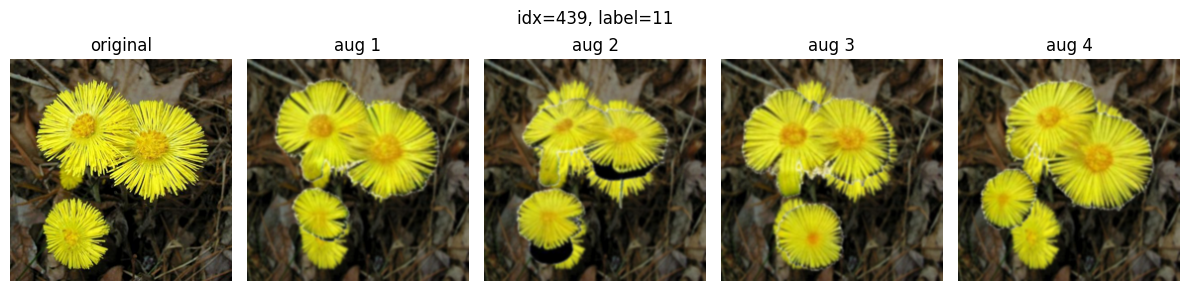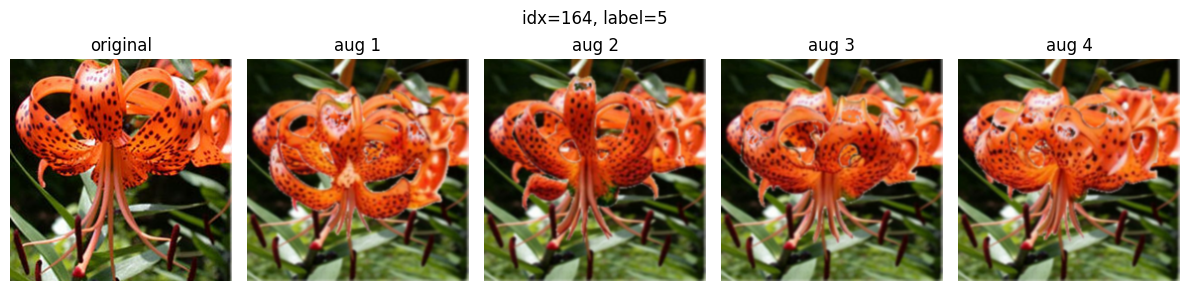


###Custom Dataset class

In [ ]:
def _find_normalize(transforms):
    # t can be a single transform or a Compose
    if hasattr(transforms, "mean") and hasattr(transforms, "std"):
        return transforms
    if hasattr(transforms, "transforms"):
        for tt in transforms.transforms:
            if hasattr(tt, "mean") and hasattr(tt, "std"):
                return tt
    return None

def replace_white_with_blur(fg_img, bg_img):
    """
    Replace white pixels in `fg_img` with pixels from a blurred `bg_img`.
    Both are PIL RGB images. We resize `bg_img` to match `fg_img` automatically.
    """
    if fg_img.size != bg_img.size:
        bg_img = bg_img.resize(fg_img.size, resample=Image.BICUBIC)

    fg = np.array(fg_img)
    bg = np.array(bg_img)

    # Detect 'white' pixels (over 215)
    mask = np.all(fg >= 215, axis=-1)

    # Replace 'white' pixels with blurred background
    fg[mask] = bg[mask]
    return Image.fromarray(fg)

class DatasetWithAugmentations(torch.utils.data.Dataset):
    def __init__(self, original_dataset, aug_root, transform, starting_index=0):
        self.dataset = original_dataset
        self.transform = transform
        self.aug_root = aug_root
        self.starting_index = starting_index # this is needed because of the split between base and novel categories

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load original image and label
        image, label = self.dataset[idx]
        image_tensor = self.transform(image)

        # Load augmentations from folder
        folder_index = idx + self.starting_index
        aug_dir = os.path.join(self.aug_root, str(folder_index))
        aug_images = []

        if os.path.isdir(aug_dir):
            # List and sort the augmentation files for deterministic ordering
            aug_filenames = sorted([
                f for f in os.listdir(aug_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ])

            for filename in aug_filenames:
                aug_path = os.path.join(aug_dir, filename)
                aug_image = Image.open(aug_path).convert("RGB")
                aug_with_blur = replace_white_with_blur(aug_image, image) # Replace white background
                blurred_final = aug_with_blur.filter(ImageFilter.GaussianBlur(radius=1)) # Blur slightly to "merge"
                aug_tensor = self.transform(blurred_final)
                aug_images.append(aug_tensor)

        return [image_tensor] + aug_images, label

    @property
    def labels(self):
        return self.dataset._labels


### Custom evaluation function

The following function is an adapted version of the orignal eval function, made to handle the custom dataset class. In this function, the distance between the original image embedding and the generated images embeddings is computed and a threshold is applied to discard faulty generated images (Zero123 may fail to recognize the correct subject). This threshold is tailored to CLIP visual encoder and considering that our generated views should not be too different from the original image.

To make our hard work count, we tried three different accuracy computations:
1. Visual embeddings averaging -> 1 prediction
2. 5 predictions -> scores averaging
3. 5 predictions -> ensamle voting

Unfortunately, they all produce very similar results, and none of them is positive 😞

*NB: since for each image 5 similarities are computed, this evaluation will take 5 times the time of the previous one!*

In [ ]:
@torch.no_grad()
def eval_aug(model, dataset, categories, batch_size, device, text_features, threshold=0.0, label=""):
    """
    Evaluation function for dataset with multiple views per sample.

    Implements three methods:
    1) Embedding averaging
    2) Similarity averaging
    3) Weighted voting

    Returns metrics for each method.
    """

    model.eval()
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: x)

    # Counters for each method
    correct_emb_avg = 0
    correct_sim_avg = 0
    correct_vote = 0
    total = 0

    # Similar lists can be added for top5, top10 if needed...
    discarded_aug_views = 0

    for batch_idx, batch in enumerate(tqdm(dataloader, desc=label)):
        # batch is a list of tuples: [([img_tensors], label), ...]

        # Flatten all images in batch for encoding
        all_images = [] # contains all images of the batch
        sample_image_counts = []  # is a list where each element is the number of total images per orginal image in the batch
        labels = [] # list of labels

        for imgs_list, lbl in batch: #imgs_list is the list of all images (original+augmented), lbl is the correct label
            sample_image_counts.append(len(imgs_list))
            all_images.extend(imgs_list)
            labels.append(contig_cat2idx[lbl])

        labels = torch.tensor(labels, dtype=torch.long).to(device)

        # Stack all images into a batch tensor
        all_images_tensor = torch.stack(all_images).to(device)

        # Encode all images at once
        image_features = model.encode_image(all_images_tensor)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Split embeddings back per sample
        embeddings_per_sample = [] # list of lists where each inner list is a list of the CLIP embeddings associated with an original image (embedding of the original image plus embeddings of the augmented ones)
        embedding_distances = []  # stores per-view cosine distances (1 - sim)
        start_idx = 0
        for count in sample_image_counts:
            embeddings_per_sample.append(image_features[start_idx : start_idx + count])
            start_idx += count

        # Prepare to store similarity scores for each method
        sim_emb_avg = []
        sim_sim_avg = []
        sim_vote = []

        # Process each sample separately
        for i, emb_list in enumerate(embeddings_per_sample):
            original_emb = emb_list[0]

            if threshold == 0.0:
                # Ignore all augmentations — use only the original embedding
                emb_list = original_emb.unsqueeze(0)
            else:
                filtered_embs = [original_emb]
                for aug in emb_list[1:]:
                    dist = 1.0 - torch.nn.functional.cosine_similarity(original_emb.unsqueeze(0), aug.unsqueeze(0)).item()
                    embedding_distances.append(dist)

                    if dist <= threshold:
                        filtered_embs.append(aug)

                if len(filtered_embs) == 1:
                    discarded_aug_views += 1

                emb_list = torch.stack(filtered_embs) if len(filtered_embs) > 1 else original_emb.unsqueeze(0)


            # 1) Embedding averaging
            avg_emb = emb_list.mean(dim=0)
            avg_emb = avg_emb / avg_emb.norm()
            sim1 = avg_emb @ text_features.T  # (num_classes,)

            # 2) Similarity averaging
            sims = emb_list @ text_features.T  # (num_views, num_classes)
            sim2 = sims.mean(dim=0)

            # 3) Rank-based voting with tunable original image weight
            topk = 3
            original_weight = 2.0  # how much to boost the original image

            sims = emb_list @ text_features.T  # (num_views, num_classes)
            _, topk_indices = sims.topk(topk, dim=1)  # top-k indices only

            # Custom rank weights: top1 = 2, top2 = 1, top3 = 0.5
            rank_weights = torch.tensor([2.0, 1.0, 0.5], device=device)

            votes = torch.zeros(len(categories), device=device)

            for view_idx, preds in enumerate(topk_indices):
                weight = original_weight if view_idx == 0 else 1.0
                for rank, cls_idx in enumerate(preds):
                    votes[cls_idx] += rank_weights[rank] * weight

            sim3 = votes


            sim_emb_avg.append(sim1)
            sim_sim_avg.append(sim2)
            sim_vote.append(sim3)

        # Stack similarities per sample
        sim_emb_avg = torch.stack(sim_emb_avg)  # (batch_size, num_classes)
        sim_sim_avg = torch.stack(sim_sim_avg)
        sim_vote = torch.stack(sim_vote)

        # Compute top-k for each method
        def compute_metrics(sim_matrix):
            top10 = sim_matrix.topk(10, dim=-1)
            top10_indices = top10.indices
            top10_values = top10.values

            # Top-1, 5, 10 accuracy
            top1 = (top10_indices[:, 0] == labels).sum().item()
            top5 = sum([labels[i] in top10_indices[i, :5] for i in range(len(labels))])
            top10_acc = sum([labels[i] in top10_indices[i, :10] for i in range(len(labels))])


            return top1, top5, top10_acc

        # Compute metrics for each method
        top1_emb, top5_emb, top10_emb = compute_metrics(sim_emb_avg)
        top1_sim, top5_sim, top10_sim = compute_metrics(sim_sim_avg)
        top1_vote, top5_vote, top10_vote = compute_metrics(sim_vote)

        correct_emb_avg += top1_emb
        correct_sim_avg += top1_sim
        correct_vote += top1_vote
        total += len(labels)

        # Cleanup
        del all_images_tensor, image_features, embeddings_per_sample
        del sim_emb_avg, sim_sim_avg, sim_vote

        if batch_idx % 10 == 0:
            aggressive_cleanup()

    # Calculate final accuracies and mean gaps
    def safe_mean(lst):
        return sum(lst) / len(lst) if len(lst) > 0 else 0

    results = {
        "embedding_avg": {
            "top1": correct_emb_avg / total,
        },
        "similarity_avg": {
            "top1": correct_sim_avg / total,
        },
        "weighted_vote": {
            "top1": correct_vote / total,
        },
    }

    print(f"\nTotal samples evaluated: {total}\n")
    for method_name, stats in results.items():
        print(f"Method: {method_name}")
        print(f"  ✅ Top-1 Accuracy: {stats['top1']*100:.2f}%")

    return results


### Complete Aug Pipeline Execution

In [ ]:
def run_aug_pipeline():
    """
    Run complete evaluation suite with proper memory management for augmented dataset

    Evaluations performed:
    1. Standard prompts on base classes
    2. Standard prompts on novel classes
    3. LLM-enhanced prompts on base classes (if available)
    4. LLM-enhanced prompts on novel classes (if available)

    Returns:
        Dictionary containing all evaluation results
    """
    print("🚀 Starting memory-optimized CLIP evaluation suite...")

    # Try to load LLM-generated prompts
    try:
        with open("generated_prompts.json", "r") as f:
            generated_prompts_for_classes = json.load(f)
        has_llm_prompts = True
        print("✅ Found generated prompts file")
        print(f"📊 Loaded prompts for {len(generated_prompts_for_classes)} classes")
    except FileNotFoundError:
        print("❌ No generated prompts found. Will only run standard evaluation.")
        has_llm_prompts = False

    results = {}

    # Use context manager for proper model lifecycle management
    with clip_model_context("ViT-B/16") as (model, preprocess, device):
        print(f"📱 Using device: {device}")
        batch_sz = 128

        # Load and prepare datasets
        print("\n📥 Loading and preparing datasets...")
        train_set, val_set, test_set = get_data(transform=None)
        base_classes, novel_classes = base_novel_categories(train_set)

        # Split datasets by base/novel classes
        test_base, test_novel = split_data(test_set, base_classes)
        test_base_number_of_images = len(test_base) # this is needed to correctly link images with their augmentations

        # Define the two augmented datasets
        test_base_augmented:DatasetWithAugmentations = DatasetWithAugmentations(original_dataset=test_base, aug_root="./CLIP-zero-shot/augmentations", transform=preprocess)
        test_novel_augmented:DatasetWithAugmentations = DatasetWithAugmentations(original_dataset=test_novel, aug_root="./CLIP-zero-shot/augmentations", transform=preprocess, starting_index=test_base_number_of_images)

        print(f"📊 Dataset prepared:")
        print(f"   Base classes: {len(base_classes)} Novel classes: {len(novel_classes)}")
        print(f"   Test base samples: {len(test_base)} Test novel samples: {len(test_novel)}")

        threshold_value = 0.125 # threshold for cosine difference. Above this value augmented images will be discarded as they differ too much from the original one
        # EVALUATIONS 3: Standard Prompts with Augmented Dataset
        print("\n" + "="*60)
        print("🔄 EVALUATION 3a: Standard Prompts on Base Classes Augmented")
        print("="*60)

        base_text_features = get_text_features_standard(model, base_classes, device)
        try:
            results['standard_base_augmented'] = eval_aug(
                model=model,
                dataset=test_base_augmented,
                categories=base_classes,
                batch_size=batch_sz,
                device=device,
                text_features=base_text_features,
                threshold=threshold_value,
                label="🧠 Zero-shot evaluation on Base Classes Augmented with Standard Prompts"
            )
        finally:
            del base_text_features
            aggressive_cleanup()

        print("\n" + "="*60)
        print("🔄 EVALUATION 3b: Standard Prompts on Novel Classes Augmented")
        print("="*60)

        novel_text_features = get_text_features_standard(model, novel_classes, device)
        try:
            results['standard_novel_augmented'] = eval_aug(
                model=model,
                dataset=test_novel_augmented,
                categories=novel_classes,
                batch_size=batch_sz,
                device=device,
                text_features=novel_text_features,
                threshold=threshold_value,
                label="🧠 Zero-shot evaluation on Novel Classes Augmented with Standard Prompts"
            )
        finally:
            del novel_text_features
            aggressive_cleanup()

        # EVALUATIONS 4: LLM-Enhanced Prompts (if prompts available) with Augmented Dataset
        if has_llm_prompts:
            print("\n" + "="*60)
            print("🔄 EVALUATION 4a: LLM-Enhanced Prompts on Base Classes Augmented")
            print("="*60)

            base_llm_features = get_llm_text_features(
                model, generated_prompts_for_classes, base_classes, CLASS_NAMES, device
            )
            try:
                results['llm_base_augmented'] = eval_aug(
                    model=model,
                    dataset=test_base_augmented,
                    categories=base_classes,
                    batch_size=batch_sz,
                    device=device,
                    text_features=base_llm_features,
                    threshold=threshold_value,
                    label="🌸 Zero-shot eval with LLM prompts on Base Classes Augmented"
                )
            finally:
                del base_llm_features
                aggressive_cleanup()

            print("\n" + "="*60)
            print("🔄 EVALUATION 4b: LLM-Enhanced Prompts on Novel Classes Augmented")
            print("="*60)

            novel_llm_features = get_llm_text_features(
                model, generated_prompts_for_classes, novel_classes, CLASS_NAMES, device
            )
            try:
                results['llm_novel_augmented'] = eval_aug(
                    model=model,
                    dataset=test_novel_augmented,
                    categories=novel_classes,
                    batch_size=batch_sz,
                    device=device,
                    text_features=novel_llm_features,
                    threshold=threshold_value,
                    label="🌸 Zero-shot eval with LLM prompts on Novel Classes Augmented"
                )
            finally:
                del novel_llm_features
                aggressive_cleanup()

    return results

print("✅ Main evaluation suite function defined")

✅ Main evaluation suite function defined


### Analyze and display aug results

In [ ]:
def analyze_results_aug(results):
    print("\n📊 Detailed Results Summary")

    # Optional: Pretty Table (if tabulate is installed)
    try:
        from tabulate import tabulate

        table_data = []
        for method, stats in results.items():
            row = [method]
            row.append(f"{stats['top1'] * 100:.2f}%")
            row.append(f"{stats.get('avg_gap_top1', 'N/A'):.2f}%" if 'avg_gap_top1' in stats else "—")
            table_data.append(row)

        headers = ["Method", "Top-1 Accuracy", "Avg. Confidence Gap"]
        print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
    except ImportError:
        print("Install `tabulate` for prettier table (pip install tabulate)")
        for method, stats in results.items():
            print(f"→ {method}: Top-1 Accuracy = {stats['top1']*100:.2f}%, Avg. Gap = {stats.get('avg_gap_top1', 'N/A'):.2f}%")

    # --- Bar Plots ---
    methods = list(results.keys())
    top1_values = [results[m]['top1'] * 100 for m in methods]
    gap_values = [results[m].get('avg_gap_top1', None) for m in methods]

    sns.set(style="whitegrid")

    # 1. Top-1 Accuracy Barplot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=methods, y=top1_values, palette="crest")
    plt.title("Top-1 Accuracy per Method", fontsize=14)
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=15)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # 2. Confidence Gap Barplot (only for methods that have it)
    valid_gap_indices = [i for i, g in enumerate(gap_values) if g is not None]
    if valid_gap_indices:
        plt.figure(figsize=(10, 5))
        sns.barplot(
            x=[methods[i] for i in valid_gap_indices],
            y=[gap_values[i] for i in valid_gap_indices],
            palette="flare"
        )
        plt.title("Avg. Confidence Gap (Top-1 Hit)", fontsize=14)
        plt.ylabel("Gap (%)")
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()


### Finally time to run pt2!

In [ ]:
results = run_aug_pipeline()

In [ ]:
analyze_results_aug(results=results)

## 8. Conclusions

Thanks for sticking with us through this (admittedly long) notebook! We're genuinely proud of what came out of it — especially the boost we got from using LLM-generated prompts to improve CLIP’s zero-shot performance. As for the dataset augmentation… well, it didn’t help accuracy (at all), but the generated images looked cool, and the idea was solid enough that we had to give it a shot. All in all, totally worth the detour.

Thanks again for reading — and if you're up for more, feel free to dive into the appendix! 👋👋

# 📘 Appendix


### Zero-1-to-3 model for image augmentation
Here there is a quick demo that shows how we generated the different views for each test image in the dataset

⚠ Restart the session after running the following cell. The download of the model will take about 2 minutes

In [ ]:
!git clone --recurse-submodules https://github.com/FilippoAdami/Zero123-Acc # that's our repo since the original one was outdated and didn't work, plus we had to create some new functions to adapt it to our use case
%cd Zero123-Acc/
!bash setup.sh # file with all the commands to run, including installing dependencies

# ❗ Reload session now, important since the repo relies on outdated versions of packages preinstalled on Colab, the restart is necessary to override them

### Model setup

In [ ]:
%cd Zero123-Acc/
%run setup_model.py


import torch
import clip
from torchvision.datasets import Flowers102
from torchvision import transforms

flowers = Flowers102(root="./data", split="test", download=True)  # We re-download the dataset because it's erased after session restart together with local variables (CLASS_NAMES)

CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]

/content/Zero123-Acc
✅ Python path setup complete.
⚙️ Initializing models on cuda:0...


Initializing Zero123 models...

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1614: UserWarning: The following device_map keys do not match any submodules in the model: ['second_stage_model', 'betas', '_buffers', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod', 'posterior_variance', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2']
  warnings.warn(


Instantiating AutoFeatureExtractor...

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Models initialized on cuda:0.

✅ Models and sampler are loaded and ready.


100%|██████████| 345M/345M [00:13<00:00, 25.7MB/s]
100%|██████████| 502/502 [00:00<00:00, 756kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 23.8MB/s]


### Augmentation generation
❗ Uncomment the last line of the following cell to generate the views

🕐 It should take more or less 2 minutes for 4 views because part of the model has to be loaded in CPU due to colab memory constraints.


--- Generating Views for 'watercress' ---


Loaded input image from: /content/input.jpg

Original input_im size: (519, 500)

Infer foreground mask (preprocess_image) took 2.409s.

Generating view: hor_angle=0, ver_angle=-30, zoom=0.0

Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|██████████| 45/45 [00:33<00:00,  1.36it/s]


Generating view: hor_angle=0, ver_angle=30, zoom=0.0

Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]


Generating view: hor_angle=-30, ver_angle=0, zoom=0.0

Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|██████████| 45/45 [00:37<00:00,  1.21it/s]


Generating view: hor_angle=30, ver_angle=0, zoom=0.0

Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


✅ View generation complete.


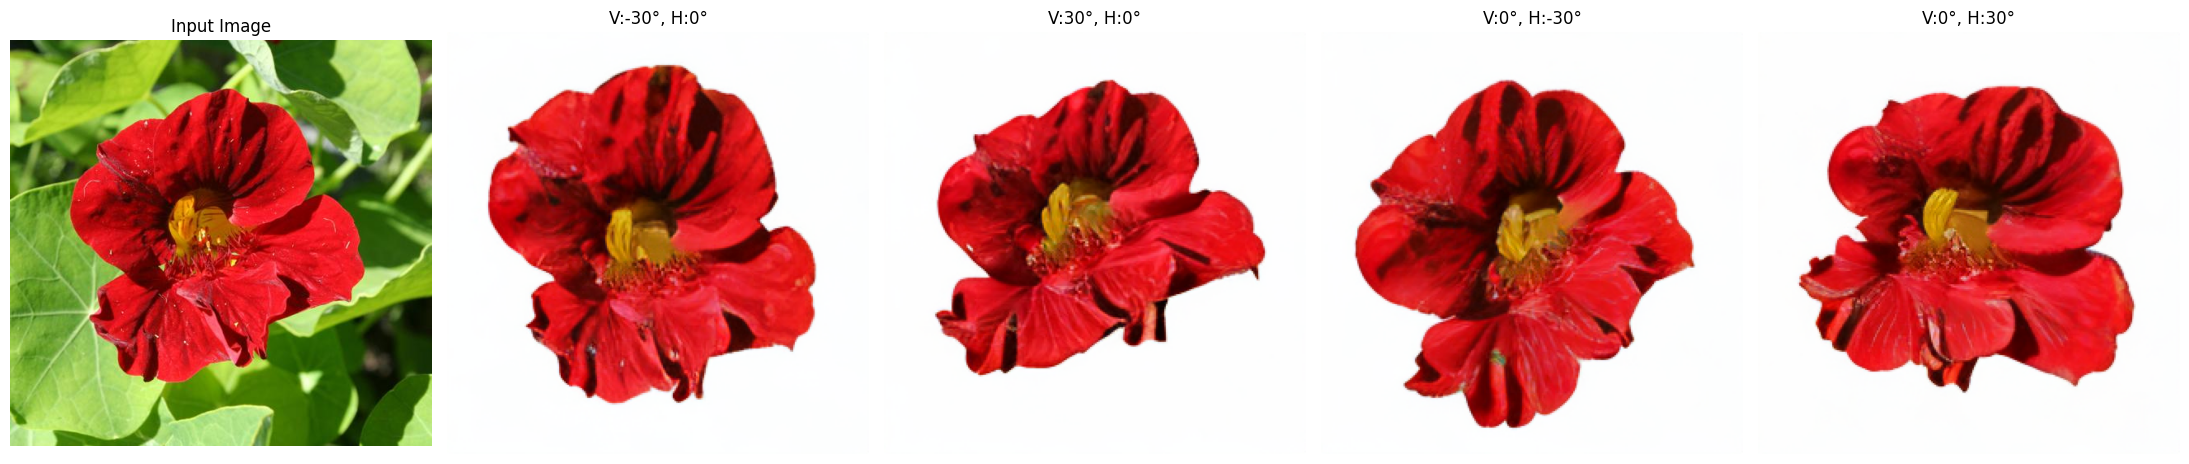

<Figure size 640x480 with 0 Axes>

In [ ]:
from os.path import exists
from app import generate_novel_views
from PIL import Image
import random
import matplotlib.pyplot as plt


def generate_augmentation(sample_id):
  test_img, test_label = flowers[sample_id]
  input_image_path_1 = '/content/input.jpg'
  test_img.save(input_image_path_1)

  # Generate Zero123 views
  print(f"\n--- Generating Views for '{CLASS_NAMES[test_label]}' ---")
  images = generate_novel_views(img_path=input_image_path_1)
  print(f"✅ View generation complete.")

  all_images = [test_img] + images
  view_angles = ['Input Image', 'V:-30°, H:0°', 'V:30°, H:0°', 'V:0°, H:-30°', 'V:0°, H:30°']

  # Display in grid
  fig, axs = plt.subplots(1, 5, figsize=(22, 5))
  for i, img in enumerate(all_images):
      axs[i].imshow(img)
      axs[i].axis('off')
      axs[i].set_title(view_angles[i], fontsize=12)

  plt.tight_layout()
  plt.show()

sample_id = random.randint(0, len(flowers)-1)
#generate_augmentation(sample_id) # AFTER HAVING RESTARTED THE SESSION UNCOMMENT THIS

## Uncertainty Sample Detection
As part of the initial exploration, we developed an Uncertainty Sample Detector to identify potentially misclassified samples from CLIP’s predictions. The idea was to selectively apply our computationally expensive zero-shot classification technique only to uncertain cases, thereby improving overall accuracy without significantly increasing processing time. The detector was designed to maximize recall on misclassified samples (to catch as many CLIP errors as possible) and maximize precision on correctly classified ones (to avoid unnecessary reprocessing).

To keep the system lightweight and easily integrable in a broader pipeline, we deliberately avoided deep learning-based solutions. Instead, we implemented a **Random Forest classifier** trained on a set of 8 hand-crafted features extracted from CLIP's output, designed to capture different aspects of **prediction uncertainty**. These include, for example, the confidence gap between top classes and the entropy of the probability distribution. Feature distributions were analyzed separately for correctly and incorrectly classified samples to verify their discriminative power.

The performance of the detector is illustrated below through its confusion matrix, which shows how the model distinguishes between correctly and incorrectly classified samples.

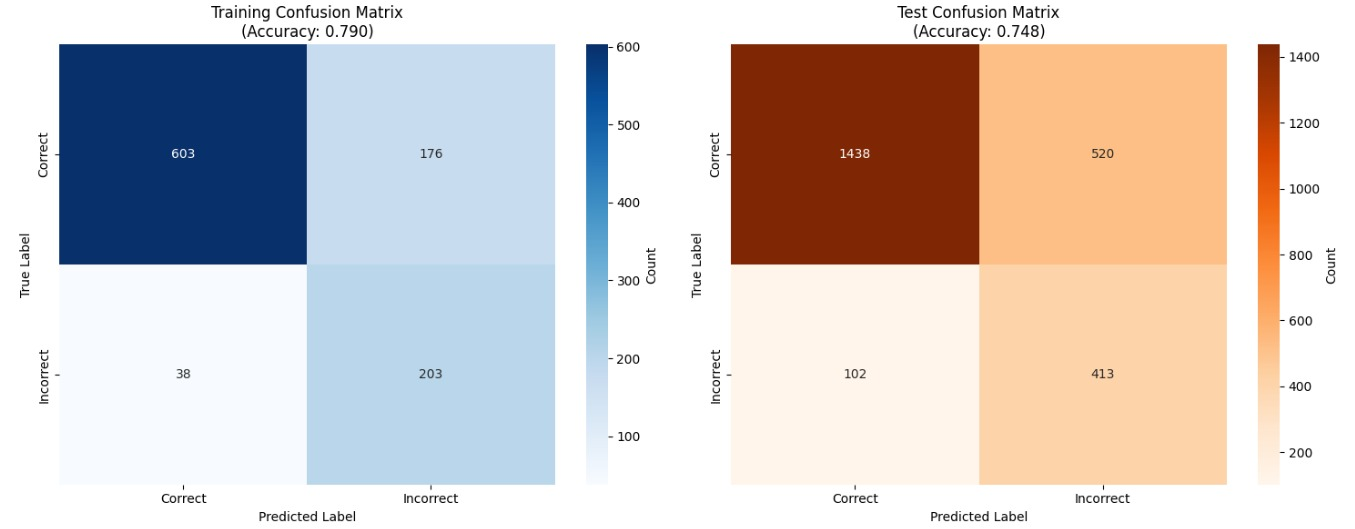

However, after further analysis, we opted for a simpler and more robust approach by applying the augmentation-based classification to all samples. This avoided the risk of false negatives (i.e., errors that would be missed by the detector) and simplified the pipeline.

The detector implementation remains available in the repository for reference and potential future use:  


[🔗 Uncertainty Sample Detection Notebook](https://github.com/matteogrisenti/CLIP-zero-shot/blob/main/uncertainty_sample_detection.ipynb)

## 🔄 Exploratory Idea: Iterative Prompt Refinement Based on CLIP Uncertainty

While our final implementation uses a fixed set of LLM-generated prompts and pre-generated augmented images, we also explored the idea of making the prediction process **iterative and adaptive**, guided by CLIP’s confidence.

The central motivation comes from a gap we noticed in the literature: although **prompt optimization** has received increasing attention (e.g., CoCoOp [Zhou et al., 2022](https://arxiv.org/abs/2109.01134), IPO [Du et al.](https://arxiv.org/abs/2410.15397), GPT-based prompts [Maniparambil et al., 2023](https://arxiv.org/abs/2307.11661v2)), **test-time refinement loops based on uncertainty signals** are largely unexplored.

### 🧠 Core Idea

Instead of relying on a fixed prompt set, the system could:
1. Perform a **first-pass prediction** using initial prompts and available image views.
2. Measure **uncertainty** — for example, high entropy over the top-5 predictions or a small margin between the top classes.
3. If confidence is low:
   - Trigger an LLM to generate **more focused prompts**, targeted specifically at differentiating the uncertain top classes.
   - Optionally, generate new **augmented views** of the image to give CLIP more visual information.
4. Recompute CLIP predictions with the new prompts and views, aiming for improved confidence.

This approach could dynamically refine the classification process in challenging, fine-grained cases.

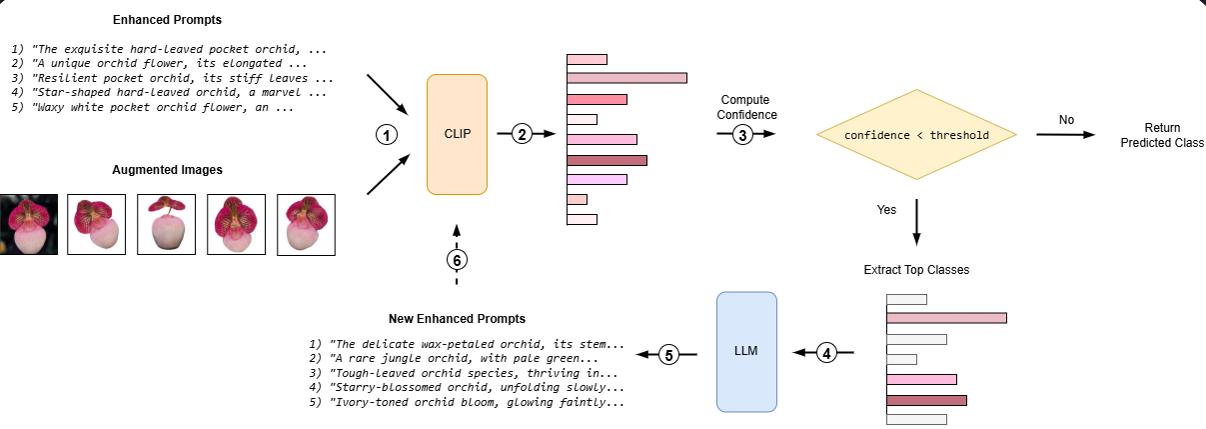

### 🧪 Why We Didn't Implement It

Although promising, this strategy was not included in our final implementation due to practical constraints:
- **Generating additional views on the fly** using diffusion models was too computationally expensive for our available resources, especially in a Colab-based setup.
- Similarly, prompt refinement using **Large Language Diffusion Models** — which allow token-level masking and iterative “fill-in-the-middle” synthesis [[Li et al., 2023](https://arxiv.org/abs/2205.14217); [Hoogeboom et al., 2022](https://arxiv.org/abs/2102.05379)] — was considered. However, these models are **still heavy and slow at inference**, especially when compared to autoregressive LLMs.

### 📚 Relation to Literature

This idea connects with:
- The **denoising-based iteration** process in diffusion LMs, which could be used to refine class prompts conditioned on prior similarity scores. ([Li et al., 2022](https://arxiv.org/abs/2205.14217))
- Prompt diversification techniques (e.g., prompt ensembling) that improve CLIP’s robustness.
- Image-based test-time augmentation techniques like DiffTPT [Feng et al., 2023](https://arxiv.org/abs/2308.06038) and MTA [Zanella & Ben Ayed, 2024](https://arxiv.org/abs/2405.02266).

---

Although we didn’t deploy this strategy, we believe it remains a **novel and underexplored direction** that could improve vision-language reasoning without fine-tuning — by dynamically adapting both **text** and **image** inputs based on the model’s own uncertainty.
